#199110629 - AI Coursework
##Using AdaBoost to predict medical costs

In [1]:
#Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Read in data
insurance_data = pd.read_csv('insurance.csv')

In [2]:
#We first need to explore the data to ensure it is suitable for our algorithm and decide on the transformations that will need to be utilised.
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
#Ensuring no data is missing from the dataset
insurance_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
#Get a feeling for the basic statistics
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


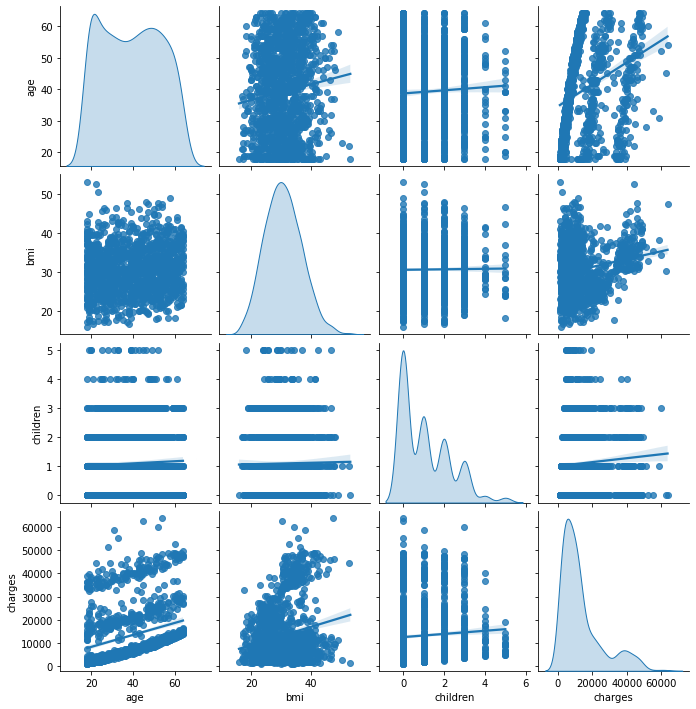

In [5]:
#Visualise numerics
sns.pairplot(insurance_data, kind="reg", diag_kind="kde")

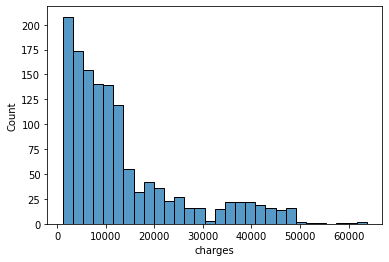

In [6]:
#We can see the charges are generally clustered around zero but with large tail events, these will need to be scaled.
ax = sns.histplot(insurance_data['charges'])

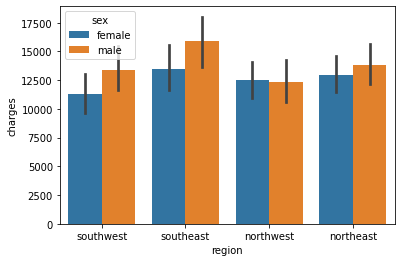

In [7]:
ax = sns.barplot(x='region', y='charges', hue='sex', data=insurance_data)

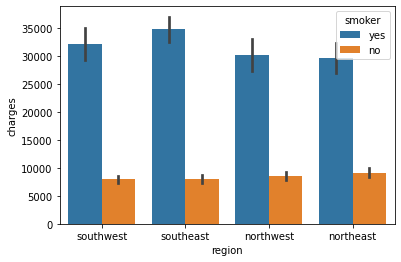

In [8]:
ax = sns.barplot(x='region', y='charges', hue='smoker', data=insurance_data)

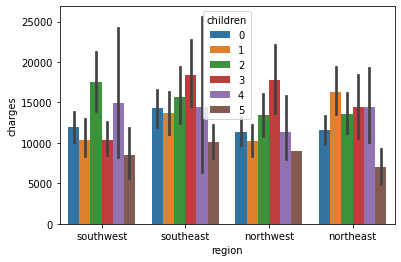

In [9]:
ax = sns.barplot(x='region', y='charges', hue='children', data=insurance_data)

We can see that smoker is the greatest decider in total costs so we will examine this further.

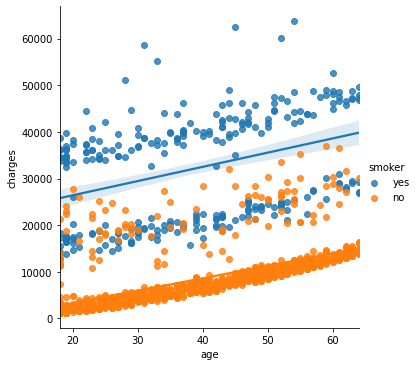

In [10]:
ax = sns.lmplot(x = 'age', y = 'charges', hue='smoker', data=insurance_data)

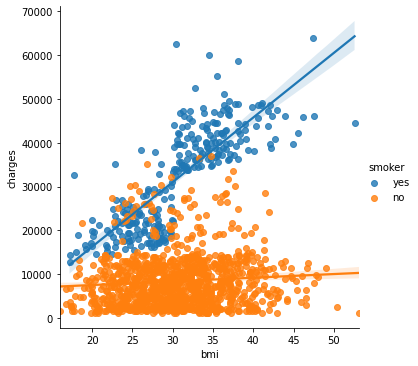

In [11]:
ax = sns.lmplot(x = 'bmi', y = 'charges', hue='smoker', data=insurance_data)

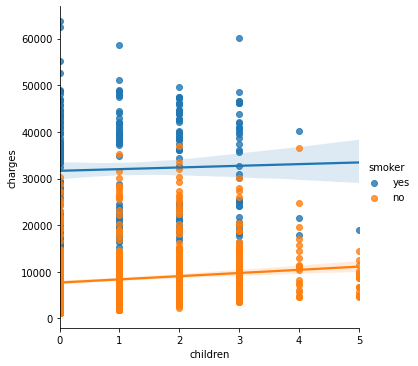

In [12]:
ax = sns.lmplot(x = 'children', y = 'charges', hue='smoker', data=insurance_data)

In [13]:
#Here we will test the transformations we want to use.
#Convert smoker to binary values
cleanup_smoker = {"smoker":     {"unknown": 0, "no": 0, "yes": 1}}
insurance_data_processed = insurance_data.replace(cleanup_smoker)
#One hot encoding for categorical values
model_data = pd.get_dummies(insurance_data_processed, columns=["sex", "region"],prefix=["sex","region"])
model_data.head()

,age,bmi,children,smoker,charges,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,16884.92400,1,0,0,0,0,1
1,18,33.770,1,0,1725.55230,0,1,0,0,1,0
2,28,33.000,3,0,4449.46200,0,1,0,0,1,0
3,33,22.705,0,0,21984.47061,0,1,0,1,0,0
4,32,28.880,0,0,3866.85520,0,1,0,1,0,0


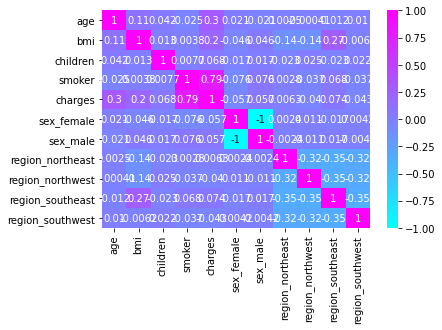

In [14]:
ax = sns.heatmap(model_data.corr(), annot=True, cmap='cool')

Here we can see confirmation that smoker is the most correlated with charges and age, bmi & children are lightly correlated. Interestingly neither sex seem to have a larger correlation in charges than the other.

In [15]:
#Now we will recreate these transformations as sklearn pipeline steps
X = insurance_data.drop(['charges'],axis=1)
Y = insurance_data['charges']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

numeric_features = ["age", "bmi", "children"]
numeric_transformer = StandardScaler()

categoric_features = ["smoker", "sex", "region"]
categoric_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categoric_transformer, categoric_features)
    ]
)

#Pre tuned models

In [16]:
#sklearn methods
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [17]:
#Function to run different methods
def evaluate_model(model):
    #Prediction using test set
    Y_pred = model.predict(X_test)

    # Printing the metrics
    print("Model evaluation figures:")
    print('R2 square:', metrics.r2_score(Y_test, Y_pred))
    print('Explained Variance', metrics.explained_variance_score(Y_test, Y_pred))
    print('MAE: ', metrics.mean_absolute_error(Y_test, Y_pred))
    print('MSE: ', metrics.mean_squared_error(Y_test, Y_pred))
    
def fit_model(function):
    model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", function())]
    )

    model.fit(X_train, Y_train)
    evaluate_model(model)
    return model

In [18]:
glm_reg = fit_model(PoissonRegressor)

Model evaluation figures:
R2 square: 0.7849492830913165
Explained Variance 0.7850929722530705
MAE:  3937.314813630899
MSE:  32449247.768634934


In [19]:
rf_reg = fit_model(RandomForestRegressor)

Model evaluation figures:
R2 square: 0.8508231411616045
Explained Variance 0.8513344164989007
MAE:  2572.919402994801
MSE:  22509466.247672454


In [20]:
bag_reg = fit_model(BaggingRegressor)

Model evaluation figures:
R2 square: 0.8432487002857837
Explained Variance 0.8436888928825774
MAE:  2606.5643689360695
MSE:  23652382.264049895


In [21]:
ada_reg = fit_model(AdaBoostRegressor)

Model evaluation figures:
R2 square: 0.8209058347678442
Explained Variance 0.8422619164258014
MAE:  4047.7102166652094
MSE:  27023722.7063176


#Hyper parameter tuning

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [23]:
#GLM Model
#alpha
alpha = [float(x) for x in np.linspace(0, 2, 50)]
#intercept
fit_intercept = [True,False]
#max iterations
max_iter = [int(x) for x in np.linspace(50, 150, 20)]
#warm start
warm_start = [True,False]

random_grid_glm = {'classifier__alpha': alpha,
                   'classifier__fit_intercept': fit_intercept,
                   'classifier__max_iter': max_iter,
                   'classifier__warm_start': warm_start}

glm_random = RandomizedSearchCV(estimator=glm_reg, param_distributions= random_grid_glm, n_iter= 100, cv = 3, verbose=0, random_state=42, n_jobs=-1)

In [24]:
glm_random.fit(X_train, Y_train)
glm_random.best_params_

{'classifier__warm_start': False,
 'classifier__max_iter': 65,
 'classifier__fit_intercept': False,
 'classifier__alpha': 1.9591836734693877}

In [25]:
#Define gridsearchcv based on random search results (Note:certain params are not centred on the best random search due to grid search finding the best parameter being the max or min value)
grid_glm = {'classifier__alpha': [1.8,1.9,2.0,2.1,2.2],
           'classifier__fit_intercept': [False,True],
           'classifier__max_iter': [60,62,64,66,68,70],
           'classifier__warm_start': [False,True]}

glm_grid = GridSearchCV(estimator= glm_reg, param_grid= grid_glm, n_jobs=-1)

In [26]:
glm_grid.fit(X_train, Y_train)
glm_grid.best_params_

{'classifier__alpha': 2.2,
 'classifier__fit_intercept': True,
 'classifier__max_iter': 60,
 'classifier__warm_start': False}

In [27]:
print("GLM Regression: No Tuning")
evaluate_model(glm_reg)
print("GLM Regression: Random Search")
evaluate_model(glm_random)
print("GLM Regression: Targeted Grid Search")
evaluate_model(glm_grid)

GLM Regression: No Tuning
Model evaluation figures:
R2 square: 0.7849492830913165
Explained Variance 0.7850929722530705
MAE:  3937.314813630899
MSE:  32449247.768634934
GLM Regression: Random Search
Model evaluation figures:
R2 square: 0.7849828958168689
Explained Variance 0.7850989535588
MAE:  3933.895851640665
MSE:  32444175.90616776
GLM Regression: Targeted Grid Search
Model evaluation figures:
R2 square: 0.7849669407774591
Explained Variance 0.7851106620876237
MAE:  3937.596512697797
MSE:  32446583.38024833


In [28]:
#Random Forrest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid_rf = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid_rf, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

In [29]:
rf_random.fit(X_train, Y_train)
rf_random.best_params_

{'classifier__n_estimators': 400,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 70,
 'classifier__bootstrap': True}

In [30]:
#Define gridsearchcv based on random search results (Note:certain params are not centred on the best random search due to grid search finding the best parameter being the max or min value)
grid_rf = {'classifier__n_estimators': [350,400,450],
       'classifier__max_features': ['auto'],
       'classifier__max_depth': [60,70,80],
       'classifier__min_samples_split': [8,10,12],
       'classifier__min_samples_leaf': [8,10,12],
       'classifier__bootstrap': [True]}

rf_grid = GridSearchCV(estimator= rf_reg, param_grid= grid_rf, n_jobs=-1)

In [31]:
rf_grid.fit(X_train, Y_train)
rf_grid.best_params_

{'classifier__bootstrap': True,
 'classifier__max_depth': 80,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 12,
 'classifier__min_samples_split': 12,
 'classifier__n_estimators': 400}

In [32]:
print("Random Forrest Regression: No Tuning")
evaluate_model(rf_reg)
print("Random Forrest Regression: Random Search")
evaluate_model(rf_random)
print("Random Forrest Regression: Targeted Grid Search")
evaluate_model(rf_grid)

Random Forrest Regression: No Tuning
Model evaluation figures:
R2 square: 0.8508231411616045
Explained Variance 0.8513344164989007
MAE:  2572.919402994801
MSE:  22509466.247672454
Random Forrest Regression: Random Search
Model evaluation figures:
R2 square: 0.8632305031055106
Explained Variance 0.863465026433801
MAE:  2517.0066451737594
MSE:  20637305.263229407
Random Forrest Regression: Targeted Grid Search
Model evaluation figures:
R2 square: 0.8636828869126961
Explained Variance 0.8638952981432902
MAE:  2583.4189887884336
MSE:  20569044.554979302


In [33]:
#Bagging Regressor
from sklearn.tree import DecisionTreeRegressor
#Base Estimator
base_estimator = [DecisionTreeRegressor(),PoissonRegressor()]
#No Estimators
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
#Max Samples
max_samples = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
#Bootstrap
bootstrap = [True,False]
#Bootstrap Features
bootstrap_features = [True,False]
#Warm Start
warm_start = [True,False]
#No jobs
n_jobs = [-1]
#Random State
random_state = [42]

# Create the random grid
random_grid_bag = {'classifier__base_estimator': base_estimator,
               'classifier__n_estimators': n_estimators,
               'classifier__max_samples': max_samples,
               'classifier__bootstrap': bootstrap,
               'classifier__bootstrap_features': bootstrap_features,
               'classifier__warm_start': warm_start,
               'classifier__n_jobs': n_jobs,
               'classifier__random_state': random_state}

bag_random = RandomizedSearchCV(estimator = bag_reg, param_distributions = random_grid_bag, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

In [34]:
bag_random.fit(X_train, Y_train)
bag_random.best_params_

{'classifier__warm_start': True,
 'classifier__random_state': 42,
 'classifier__n_jobs': -1,
 'classifier__n_estimators': 43,
 'classifier__max_samples': 79,
 'classifier__bootstrap_features': False,
 'classifier__bootstrap': False,
 'classifier__base_estimator': DecisionTreeRegressor()}

In [35]:
grid_bag = {'classifier__base_estimator': [DecisionTreeRegressor()],
               'classifier__n_estimators': [90,92,94,96],
               'classifier__max_samples': [90,92,94,96],
               'classifier__bootstrap': [True],
               'classifier__bootstrap_features': [False],
               'classifier__warm_start': [True],
               'classifier__n_jobs': [-1],
               'classifier__random_state': [42]}

bag_grid = GridSearchCV(estimator= bag_reg, param_grid= grid_bag, n_jobs=-1)

In [36]:
bag_grid.fit(X_train, Y_train)
bag_grid.best_params_

{'classifier__base_estimator': DecisionTreeRegressor(),
 'classifier__bootstrap': True,
 'classifier__bootstrap_features': False,
 'classifier__max_samples': 90,
 'classifier__n_estimators': 94,
 'classifier__n_jobs': -1,
 'classifier__random_state': 42,
 'classifier__warm_start': True}

In [43]:
print("Bagging Regression: No Tuning")
evaluate_model(bag_reg)
print("Bagging Regression: Random Search")
evaluate_model(bag_random)
print("Bagging Regression: Targeted Grid Search")
evaluate_model(bag_grid)

Bagging Regression: No Tuning
Model evaluation figures:
R2 square: 0.8432487002857837
Explained Variance 0.8436888928825774
MAE:  2606.5643689360695
MSE:  23652382.264049895
Bagging Regression: Random Search
Model evaluation figures:
R2 square: 0.854169783410424
Explained Variance 0.8563192878151726
MAE:  3037.99355086824
MSE:  22004487.58456463
Bagging Regression: Targeted Grid Search
Model evaluation figures:
R2 square: 0.8604286157640634
Explained Variance 0.8613030957959925
MAE:  2798.055019980978
MSE:  21060085.237504184


In [38]:
#AdaBoost
#Base Estimator
base_estimator = [DecisionTreeRegressor(),PoissonRegressor()]
#No Estimators
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
#Learning Rate
learning_rate = [float(x) for x in np.linspace(start = 0.1, stop = 2, num = 50)]
#Loss
loss = ['linear','square','exponential']
#Random State
random_state = [42]

# Create the random grid
random_grid_ada = {'classifier__base_estimator': base_estimator,
               'classifier__n_estimators': n_estimators,
               'classifier__learning_rate': learning_rate,
               'classifier__loss': loss,
               'classifier__random_state': random_state}

ada_random = RandomizedSearchCV(estimator = ada_reg, param_distributions = random_grid_ada, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

In [39]:
ada_random.fit(X_train, Y_train)
ada_random.best_params_

{'classifier__random_state': 42,
 'classifier__n_estimators': 83,
 'classifier__loss': 'square',
 'classifier__learning_rate': 1.4183673469387756,
 'classifier__base_estimator': DecisionTreeRegressor()}

In [40]:
grid_ada = {'classifier__base_estimator': [DecisionTreeRegressor()],
               'classifier__n_estimators': [90,95,100,105,110],
               'classifier__learning_rate': [1.9,1.92,1.94,1.96,1.98,2.0],
               'classifier__loss': ['linear','square','exponential'],
               'classifier__random_state': [42]}

ada_grid = GridSearchCV(estimator=ada_reg, param_grid=grid_ada, n_jobs=-1)

In [41]:
ada_grid.fit(X_train, Y_train)
ada_grid.best_params_

{'classifier__base_estimator': DecisionTreeRegressor(),
 'classifier__learning_rate': 1.94,
 'classifier__loss': 'linear',
 'classifier__n_estimators': 95,
 'classifier__random_state': 42}

In [44]:
print("AdaBoost Regression: No Tuning")
evaluate_model(ada_reg)
print("AdaBoost Regression: Random Search")
evaluate_model(ada_random)
print("AdaBoost Regression: Targeted Grid Search")
evaluate_model(ada_grid)

AdaBoost Regression: No Tuning
Model evaluation figures:
R2 square: 0.8209058347678442
Explained Variance 0.8422619164258014
MAE:  4047.7102166652094
MSE:  27023722.7063176
AdaBoost Regression: Random Search
Model evaluation figures:
R2 square: 0.8403399725678499
Explained Variance 0.8418940545827358
MAE:  2196.18660750597
MSE:  24091283.50449919
AdaBoost Regression: Targeted Grid Search
Model evaluation figures:
R2 square: 0.8440170312370023
Explained Variance 0.8469682064247459
MAE:  2924.208809668386
MSE:  23536447.93115022
